In [0]:
% tensorflow_version 2.x

In [87]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [0]:
# Import other required libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, GlobalMaxPool1D, Dense
from tensorflow.keras.models import Model

In [0]:
df = pd.read_csv('spam.csv', encoding = 'ISO-8859-1')

In [91]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [0]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

In [93]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
# rename columns to something better
df.columns = ['labels', 'data']

In [95]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [97]:
# Split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size = 0.33)
print(df_train.shape, df_test.shape, Ytrain.shape, Ytest.shape)

(3733,) (1839,) (3733,) (1839,)


In [0]:
# Convert sentences to tokens

MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [99]:
word2ix = tokenizer.word_index
V = len(word2ix)
print('Found', V, 'unique tokens')


Found 7327 unique tokens


In [100]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of train data tensor:', data_train.shape)

# get the sequence length
T = data_train.shape[1]

Shape of train data tensor: (3733, 162)


In [101]:
data_test = pad_sequences(sequences_test, maxlen = T)
print('Shape of test data tensor:', data_test.shape)

Shape of test data tensor: (1839, 162)


In [0]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Hidden state dimensionality
M = 15

# Note: we actually want the size of embedding to be (V + 1) x D,
# because the first index start from 1 and not 0, as 0 is used for padding.

i = Input(shape = (T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences = True)(x)
x = LSTM(M, return_sequences = True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(32, activation = 'relu')(x)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(i, x)

In [103]:
# Compile and fit

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

print('Training Model...')

r = model.fit(
    data_train, Ytrain,
    epochs = 10,
    validation_data = (data_test, Ytest)
)

Training Model...
Train on 3733 samples, validate on 1839 samples
Epoch 1/10
3733/3733 [==============================] - 6s 1ms/sample - loss: 0.4532 - accuracy: 0.8607 - val_loss: 0.3752 - val_accuracy: 0.8766
Epoch 2/10
3733/3733 [==============================] - 3s 707us/sample - loss: 0.3890 - accuracy: 0.8607 - val_loss: 0.3295 - val_accuracy: 0.8766
Epoch 3/10
3733/3733 [==============================] - 3s 705us/sample - loss: 0.2303 - accuracy: 0.8982 - val_loss: 0.1531 - val_accuracy: 0.9532
Epoch 4/10
3733/3733 [==============================] - 3s 712us/sample - loss: 0.0733 - accuracy: 0.9804 - val_loss: 0.0828 - val_accuracy: 0.9674
Epoch 5/10
3733/3733 [==============================] - 3s 724us/sample - loss: 0.0320 - accuracy: 0.9922 - val_loss: 0.0590 - val_accuracy: 0.9831
Epoch 6/10
3733/3733 [==============================] - 3s 714us/sample - loss: 0.0184 - accuracy: 0.9952 - val_loss: 0.0559 - val_accuracy: 0.9831
Epoch 7/10
3733/3733 [==========================

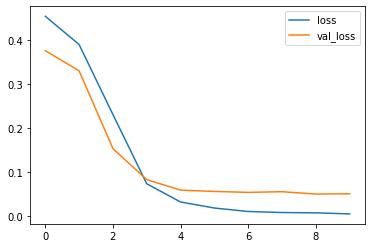

In [104]:
# Plot loss per iteration

plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

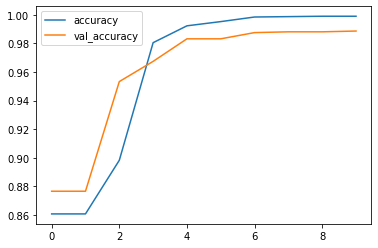

In [105]:
# Plot accuracy per iteration

plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()

In [0]:
#t = input('Enter the text to check:')
t = 'We are pleased to inform you of the result of the Lottery Winners International programs held on the 29th of April 2004 Your E-mail address attached to Ticket number 20511465897-6291 with Serial number 472-971103 drew lucky numbers 8-66-97-22-71-64 which consequently won in the 2nd category, you have therefore been approved for a lump sum payout of US$ 1,500,000.00 (One Million ,Five hundred Thousand United States Dollars).This is from a total cash prize of USD$15,000,000.00 Million shared among Ten International Lucky Winners in the Category A ( Plus )+ . CONGRATULATIONS!!!'
t = pd.core.series.Series(t)
t = tokenizer.texts_to_sequences(t)

In [0]:
t = pad_sequences(t, maxlen = T)

In [0]:
p = np.round(model.predict(t))

In [109]:
p

array([[1.]], dtype=float32)

In [0]:
#p_tst = model.predict(data_test) 

In [0]:
#pt = np.round(p_tst)

In [0]:
#for i in range(len(pt)):
#  print(i,': ', pt[i])